In [7]:
import os
import sys
import time
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut
from pysar.objects.gps import gps
from pysar import view

work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/insar_vs_gps'
os.chdir(work_dir)
print('Go to directory: '+work_dir)
gps_dir = '/Users/yunjunz/insarlab/Galapagos/GPS'
gps_site_list_file = os.path.join(gps_dir, 'DataHoldings.txt')

site_r = 'GV01' #'TOUO' #'ISCO'  'GV01'  'GV07'  None

pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
ts_file = os.path.join(pysar_dir, 'geo_timeseries_ECMWF_demErr_refDate_plane.h5')

mask_file = os.path.join(pysar_dir, 'geo_maskTempCoh.h5')
mask = readfile.read(mask_file)[0]

ts_obj = timeseries(ts_file)
geom_file = os.path.join(pysar_dir, 'geo_geometryRadar.h5')
ts_obj.open(print_msg=False)
atr = ts_obj.metadata
unit_fac = 1.

num_date = ts_obj.numDate

t0 = ts_obj.times[0] - relativedelta(months=4)
t1 = ts_obj.times[-1] + relativedelta(months=4)
start_date = t0.strftime('%Y%m%d')
end_date = t1.strftime('%Y%m%d')
start_date = '20141101'
end_date = '20180625'

def read_timeseries(site, site_r=None):
    ## Read GPS
    gps_obj = gps(site, data_dir=gps_dir)
    (gps_times,
     gps_dis,
     gps_std,
     site_lalo,
     ref_site_lalo) = gps_obj.read_gps_los_displacement(geom_file, start_date, end_date,
                                                        ref_site=site_r,
                                                        gps_comp='enu2los')
    #print('GPS {}: {}'.format(site, site_lalo))

    ## Read InSAR
    coord = ut.coordinate(atr)
    y, x = coord.geo2radar(site_lalo[0], site_lalo[1], print_msg=False)[0:2]
    lalo = coord.radar2geo(y,x,print_msg=False)[0:2]
    if site == 'GV10':
        print('{} lalo = {}'.format(site, lalo))
        print('{} yx = {}, {}'.format(site, y, x))
    box = (x, y, x+1, y+1)
    pysar_dis = readfile.read(ts_file, box=box, print_msg=False)[0]
    pysar_times = ts_obj.times
    #print('InSAR yx={}, lalo={}'.format((y,x), lalo))

    if site_r:
        try:
            ref_y, ref_x = coord.geo2radar(ref_site_lalo[0], ref_site_lalo[1], print_msg=False)[0:2]
        except:
            ref_y, ref_x = -1, -1
        if 0 <= ref_x < int(atr['WIDTH']) and 0<= ref_y < int(atr['LENGTH']):
            ref_box = (ref_x, ref_y, ref_x+1, ref_y+1)
            pysar_dis -= readfile.read(ts_file, box=ref_box, print_msg=False)[0]

    # common reference date
    comm_idx = 2
    while comm_idx < len(pysar_times):
        if pysar_times[comm_idx] not in gps_times:
            comm_idx += 1
        else:
            break
    if comm_idx == len(pysar_times):
        raise RuntimeError('InSAR and GPS do not share ANY date for site: {}'.format(site))

    comm_date = pysar_times[comm_idx]
    pysar_dis -= pysar_dis[comm_idx]

    comm_idx_gps = np.where(gps_times == comm_date)[0][0]
    gps_dis -= gps_dis[comm_idx_gps]
    gps_std = np.sqrt(gps_std**2 + gps_std[comm_idx_gps]**2)

    if mask[y, x] == 0:
        pysar_dis = None

    return gps_times, gps_dis, gps_std, pysar_times, pysar_dis, site_lalo

## Plot
def plot_timeseries(ax, site, gps_times, gps_dis, gps_std,
                    pysar_times, pysar_dis,
                    site_r=None, offset=0.):

    ax.errorbar(gps_times, gps_dis-offset, yerr=gps_std*3.,
                ms=marker_size*0.5, lw=0, alpha=1.,
                elinewidth=edge_width*0.5,  ecolor=pp.mplColors[0],
                capsize=marker_size*0.5*0.5, markeredgewidth=edge_width*0.5,
                label='GPS', zorder=1)

    ax.scatter(pysar_times, pysar_dis-offset, s=5**2, label='InSAR',
               facecolors='none', edgecolors=pp.mplColors[1], linewidth=1., alpha=0.7, zorder=2)

    ax.annotate('{}-{}'.format(site, site_r), xy=(1.03, pysar_dis[-1] - offset),
                xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                color='k', fontsize=font_size)
    return ax

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/insar_vs_gps


GV10 lalo = (-0.8490327827109341, -91.15079936672682)
GV10 yx = 1545, 965
Done.


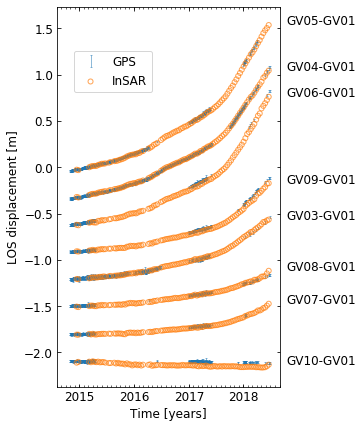

In [2]:
## Plot Displacement Time-series from InSAR and GPS
gps_sites = ['GV05', 'GV04', 'GV06', 'GV09', 'GV03', 'GV08', 'GV07', 'GV01', 'GV10']

if site_r in gps_sites:
    gps_sites.remove(site_r)
offset = 0.3

fig, ax = plt.subplots(figsize=(4, 7))
for i in range(len(gps_sites)):
    (gps_times,
     gps_dis,
     gps_std,
     pysar_times,
     pysar_dis) = read_timeseries(site=gps_sites[i], site_r=site_r)[0:5]

    if pysar_dis is not None:
        ax = plot_timeseries(ax, gps_sites[i],
                             gps_times, gps_dis, gps_std,
                             pysar_times, pysar_dis,
                             site_r=site_r,
                             offset=offset * i)

ax = pp.auto_adjust_xaxis_date(ax, ts_obj.yearList)[0]
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('LOS displacement [m]', fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size,
               bottom=True, top=True, left=True, right=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1], handles[0]], [labels[-1], labels[0]],
          loc='upper left', bbox_to_anchor=(0.05, 0.9), fontsize=font_size)
print('Done.')

plt.savefig('insar_vs_gps_point_ts_{}.jpg'.format(site_r), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

view.py /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_velocity_masked.h5 velocity --sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 --dem /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84 --dem-nocontour --vlim -0.1 0.70 -u m --lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.07 --figsize 4 2.5 --fontsize 12 --notitle --dpi 600 --nocbar --show-gps --gps-comp enu2los --ref-gps GV01 --gps-start-date 20141101 --gps-end-date 20180625 


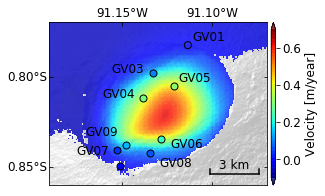

In [11]:
## map inset to show InSAR velocity field with GPS location on Sierra Negra
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
vel_file = os.path.join(pysar_dir, 'geo_velocity_masked.h5')
dem_file = os.path.join(pysar_dir, '../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84')

print_msg = False
fig, ax = plt.subplots(figsize=(5, 3))


# call view.py functions to plot InSAR background
view_cmd = ('view.py {vf} velocity --sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 '
            '--dem {df} --dem-nocontour --vlim -0.1 0.70 '
            '-u m --lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.07 --figsize 4 2.5 '
            "--fontsize 12 --notitle --dpi 600 --nocbar "
            '--show-gps --gps-comp enu2los --ref-gps GV01 '
            '--gps-start-date {t0} --gps-end-date {t1} ').format(vf=vel_file,
                                                                 df=dem_file,
                                                                 t0=start_date,
                                                                 t1=end_date)
print(view_cmd)
map
inps = view.cmd_line_parse(view_cmd.split()[1:])
inps, atr = view.check_input_file_info(inps, print_msg=print_msg)
inps = view.update_inps_with_file_metadata(inps, atr, print_msg=print_msg)
data, atr = view.readfile.read(inps.file,
                               datasetName=inps.dset[0],
                               box=inps.pix_box,
                               print_msg=print_msg)
data, inps = view.update_data_with_plot_inps(data, atr, inps, print_msg=print_msg)
ax, inps, im = view.plot_2d_matrix(ax, data, atr, inps, print_msg=print_msg)[0:3]

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "2%", pad="2%")
cbar = plt.colorbar(im, cax=cax, extend='both')
cbar.locator = ticker.MaxNLocator(nbins=4)
cbar.update_ticks()
cbar.ax.tick_params(which='both', direction='out', labelsize=font_size)
cbar.set_label('Velocity [m/year]', fontsize=font_size)


# plot GPS label
gps_sites = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,10).tolist()]
lat_off = np.array([1,  0,  0,  1, -2,  -1, -3,   2,  -2]) * 0.05 / 20.
lon_off = np.array([1, -9, -9,  1,  2,  -9,  2,  -9,  -9]) * 0.05 / 20.

gps_lats = []
gps_lons = []
for site in gps_sites:
    lat, lon = gps(site=site, data_dir=gps_dir).get_stat_lat_lon(print_msg=print_msg)
    gps_lats.append(lat)
    gps_lons.append(lon)
for i in range(len(gps_sites)):
    ax.annotate(gps_sites[i],
                (gps_lons[i]+lon_off[i],
                 gps_lats[i]+lat_off[i]),
                fontsize=font_size)

plt.savefig('insar_vs_gps_map.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [12]:
np.nanmax(data)

0.62677073

GV10 lalo = (-0.8490327827109341, -91.15079936672682)
GV10 yx = 1545, 965


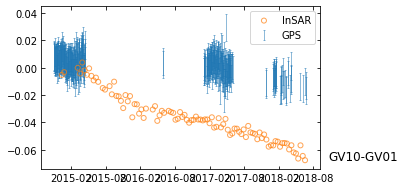

In [22]:
## plot single station timeseries - InSAR vs GPS
site = 'GV10'
site_r = 'GV01'
fig, ax = plt.subplots(figsize=(5, 3))
(gps_times,
 gps_dis,
 gps_std,
 pysar_times,
 pysar_dis) = read_timeseries(site=site, site_r=site_r)[0:5]

ax = plot_timeseries(ax, site,
                     gps_times, gps_dis, gps_std,
                     pysar_times, pysar_dis,
                     site_r=site_r,
                     offset=0)
ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
ax.legend()
plt.savefig('{}-{}.jpg'.format(site, site_r), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()